# Efecto de régimen de dosificación en PTA

In [50]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

from keras.wrappers.scikit_learn import KerasRegressor

import plotly.express as px
import plotly.graph_objects as go

import numpy as np
import pandas as pd

from matplotlib import cm, ticker
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import datasets

from google.colab import files

In [2]:
!pip install eli5
!pip install shap
import eli5
from eli5.sklearn import PermutationImportance
import shap

     |████████████████████████████████| 112kB 26.8MB/s 
     |████████████████████████████████| 358kB 20.9MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491627 sha256=c5b2d4f5b9058353912de4c3f4432c1a995ce612f4c0a94297f2a4e68ec428c5
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.



## Preprocesamiento de los datos

In [3]:
data = pd.read_csv('datosFunRenal.csv')
data.head()

,Tipo,MIC,mn,g,CLCR,DD,II,Tinf
0,1,0.062500,1.0,1,90,1000,6,2
1,1,0.067033,1.0,1,90,1000,6,2
2,1,0.071894,1.0,1,90,1000,6,2
3,1,0.077108,1.0,1,90,1000,6,2
4,1,0.082701,1.0,1,90,1000,6,2


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29400 entries, 0 to 29399
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Tipo    29400 non-null  int64  
 1   MIC     29400 non-null  float64
 2   mn      29400 non-null  float64
 3   g       29400 non-null  int64  
 4   CLCR    29400 non-null  int64  
 5   DD      29400 non-null  int64  
 6   II      29400 non-null  int64  
 7   Tinf    29400 non-null  int64  
dtypes: float64(2), int64(6)
memory usage: 1.8 MB


Se seleccionan a las variables `DD`, `ii`, `tinf`, `CLCR`, y `MIC`, como variables dependientes, se conoce por gráficos marginales que `ii`, `tinf`, y `CLCR` aportan poca información sobre el indicador PK-PD reportado en la columna `mn` (AUC/MIC >= 400).

In [5]:
X = data.loc[:, ['DD', 'II', 'Tinf', 'CLCR', 'MIC']]
X.MIC = np.log2(X.MIC) # Se convierte a logaritmo por simplicidad
y = data.mn

In [6]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

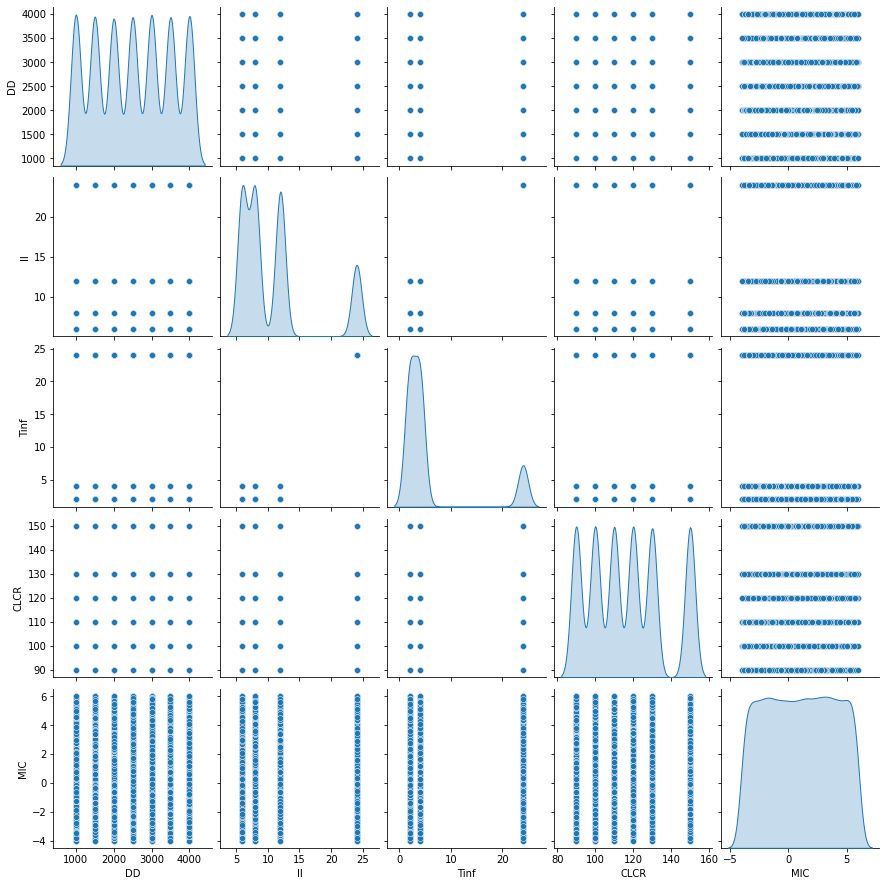

In [8]:
sns.pairplot(X_train, diag_kind='kde');

## Modelo
Ahora se especifica la configuración de la red neuronal artificial, mediante la librería `Keras`.

In [9]:
def regresorKeras():
  # Inicio de modelo
  model = tf.keras.models.Sequential([normalizer])
  # Capa de entrada
  model.add(tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(X_train.shape[1],)))
  # Capas ocultas
  model.add(tf.keras.layers.Dense(10, activation=tf.nn.relu))
  model.add(tf.keras.layers.Dense(10, activation=tf.nn.relu))
  # Capa de salida
  # Se selecciona sólo una neurona de salida: sólo hay un indicador: AUC/MIC > 400
  # La capa de salida sólo permite valores de 0 a 1 se usa fun sigmoidea
  model.add(tf.keras.layers.Dense(1, activation = tf.nn.sigmoid)) 

  model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
    loss = 'mean_absolute_error')
  return model; 

In [10]:
regresorKeras().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 5)                 11        
_________________________________________________________________
dense (Dense)                (None, 10)                60        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 302
Trainable params: 291
Non-trainable params: 11
_________________________________________________________________


In [11]:
estimator = KerasRegressor(build_fn=regresorKeras, 
                           batch_size=32, epochs=60, 
                           validation_data=(X_test.values, y_test.values),
                           verbose=0)

history = estimator.fit(X_train.values, y_train.values)

In [12]:
histDF = pd.DataFrame(history.history)
histDF['epoch'] = history.epoch
histDF.tail()

,loss,val_loss,epoch
55,0.002386,0.002954,55
56,0.002551,0.002990,56
57,0.002427,0.002280,57
58,0.002505,0.002180,58
59,0.002338,0.002778,59


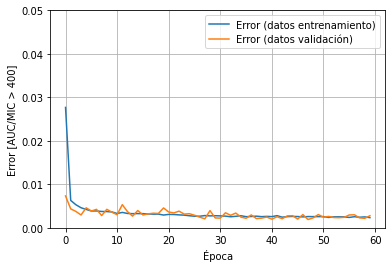

In [13]:
plt.plot(history.history['loss'], label='Error (datos entrenamiento)')
plt.plot(history.history['val_loss'], label='Error (datos validación)')
plt.ylim([0, 0.05])
plt.xlabel('Época')
plt.ylabel('Error [AUC/MIC > 400]')
plt.legend()
plt.grid(True)
plt.savefig('./010_Error_Enternamiento.pdf')

In [71]:
estimator.model.save('model_001')

import shutil
shutil.make_archive('model_001', 'zip', 'model_001')
files.download('/content/model_001.zip')

INFO:tensorflow:Assets written to: model_001/assets


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [72]:
#from tensorflow import keras
#model = keras.models.load_model('model_001.h5')

## Funciones de creación de gráficos

In [14]:
def expand_grid(x, y, xval = 'x', yval = 'y'):
    xG, yG = np.meshgrid(x, y) # Crear malla
    xG = xG.flatten() # Hacer malla 1D
    yG = yG.flatten() # Igual
    return pd.DataFrame({xval:xG, yval:yG})

In [15]:
def PTAColorScalePlotly(color1 = 'rgb(255,32,3)', color2 = 'rgb(3,148, 252)', umbral=0.85):
  return [(0.00, color1), (umbral, color1), (umbral, color2), (1.00, color2)]

In [16]:
# sampleDF = expand_grid(np.linspace(-6, 6), np.linspace(15, 30), xval = 'MIC', yval = 'DD')
# sampleDF['ii'] = 6
# sampleDF['tinf'] = 2
# sampleDF['CLCR'] = 120
# sampleDF = sampleDF[['DD', 'ii', 'tinf', 'CLCR', 'MIC']]

In [17]:
objetoDict = {
  'MIC': np.linspace(-6, 6),
  'DD': np.linspace(1000, 4000),
  'II': 6,
  'Tinf': 2,
  'CLCR': 120
}

ordenLista = ['DD', 'II', 'Tinf', 'CLCR', 'MIC']

def simularANN(variables, modelo, orden = ordenLista):
  dictArray  = [(i,k) for (i,k) in variables.items() if type(k) == np.ndarray]
  floatArray = [(i,k) for (i,k) in variables.items() if type(k) != np.ndarray]

  if len(dictArray) > 2:
    return
  
  sampleDF = expand_grid(dictArray[0][1], 
                        dictArray[1][1], 
                        xval = dictArray[0][0], 
                        yval = dictArray[1][0])

  for i in range(len(floatArray)):
    var, val = floatArray[i];
    sampleDF[var] = val

  sampleDF = sampleDF[orden]
  resultados = {'x': dictArray[0], 'y': dictArray[1], 'z': modelo.predict(sampleDF)}
  return resultados

In [18]:
DF = simularANN(objetoDict, estimator, ordenLista)

In [19]:
fig = go.Figure(go.Surface(
    contours = {
        "x": {"show": True, "start": -6, "end": +6, "size": 1, "color":"white"},
        "y": {"show": True, "start": 15, "end": 30, "size": 5, "color":"white"},
        "z": {"show": True, "start": 0, "end": 1, "size": 0.1}
    },
    x = DF['x'][1],
    y = DF['y'][1],
    z = DF['z'].reshape((50, 50)), 
    customdata = [i for i in map(lambda m: 2**m, DF['x'][1])],
    hovertemplate = '<b>MIC</b>: %{x:.2f} <br><b>DD</b>: %{y} <br><b>PTA</b>: %{z:.2f}<br>',
    colorscale = PTAColorScalePlotly()
    ))

fig.update_layout(
    title='Superficie de respuesta ANN - Vancomicina',
    scene = {
        "xaxis": {"nticks": 6},
        "zaxis": {"nticks": 4},
        'camera_eye': {"x": 0, "y": -1, "z": 0.5},
        "aspectratio": {"x": 1, "y": 1, "z": 0.5},
        "xaxis_title": "log2(PTA)",
        "yaxis_title": "Dosis diaria <br> (mg/día)",
        "zaxis_title": "PTA <br> (AUC/MIC > 400)"
        })
fig.show()

fig.write_html("011_superficiePTA_dosis_MIC.html")


In [20]:
def PTAColorScaleMatplotlib(color1 = "#ff2103", color2 = "#0394fc", umbral=0.85):
  cmap = ListedColormap([color1, color1, color2, color2])
  bounds = [0.0, umbral, 1.0]
  norm = BoundaryNorm(bounds, cmap.N)

  return {'cmap': cmap, 'bounds': bounds, 'norm': norm}

In [21]:
def grafico3DSuperficie(x, y, z, newcmp, xlab = '', ylab = '', zlab = '', 
                        lim_opt = {'xlab': [-6, +6], 'ylab': [15,30], 'zlab': [0,1]}, 
                        view_init_opt = {'elev': 10, 'azim': 12}):
  fig = plt.figure()
  ax = fig.gca(projection='3d')
  
  x1, y1 = np.meshgrid(x, y)

  ax.plot_surface(x1, y1, z, cmap=newcmp, linewidth=0, antialiased=False)
  ax.set_xlim(lim_opt['xlab'][0], lim_opt['xlab'][1])
  ax.set_ylim(lim_opt['ylab'][0], lim_opt['ylab'][1])
  ax.set_zlim(lim_opt['zlab'][0], lim_opt['zlab'][1])
  ax.set_xlabel(xlab)
  ax.set_ylabel(ylab)
  ax.set_zlabel(zlab)
  ax.view_init(elev = view_init_opt['elev'], azim = view_init_opt['azim']);
  return fig;

In [22]:
def grafico3DContorno(ax, x, y, z, cmap, xlab = '', ylab = '', title=''):
  
  x1, y1 = np.meshgrid(x, y)
  main = ax.contourf(x1, y1, z, levels = [0.0, 0.85, 1.00], cmap=cmap, 
                     #vmax=1, vmin=0
                     )
  ax.set_xlabel(xlab)
  ax.set_ylabel(ylab)
  ax.set_title(title)

  return main;

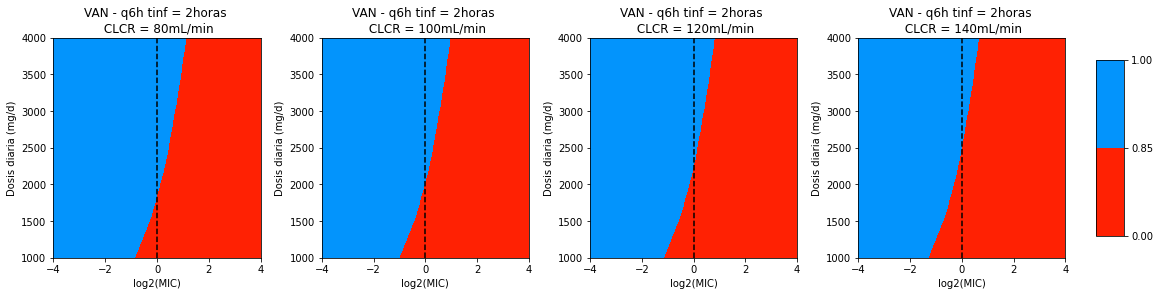

In [23]:
fig, ax = plt.subplots(1,4, figsize=(16,4), constrained_layout=True)
colscal = PTAColorScaleMatplotlib(umbral=0.85)

modelDict = {'MIC': np.linspace(-4, 4), 'DD': np.linspace(1000, 4000), 'II': 6, 'Tinf': 2, 'CLCR': 80}

# CLCR = 80
modelDict['CLCR'] = 80
df = simularANN(modelDict, estimator, ordenLista)
grafico3DContorno(ax[0], df['x'][1], df['y'][1], df['z'].reshape((50, 50)), colscal['cmap'], 
                        'log2(MIC)', 'Dosis diaria (mg/d)', 'VAN - q6h tinf = 2horas \n CLCR = 80mL/min')

ax[0].vlines(0, 1000, 4000, linestyle='dashed')

# CLCR = 100
modelDict['CLCR'] = 100
df = simularANN(modelDict, estimator, ordenLista)
grafico3DContorno(ax[1], df['x'][1], df['y'][1], df['z'].reshape((50, 50)), colscal['cmap'], 
                        'log2(MIC)', 'Dosis diaria (mg/d)', 'VAN - q6h tinf = 2horas \n CLCR = 100mL/min')
ax[1].vlines(0, 1000, 4000, linestyle='dashed')

# CLCR = 120
modelDict['CLCR'] = 120
df = simularANN(modelDict, estimator, ordenLista)
grafico3DContorno(ax[2], df['x'][1], df['y'][1], df['z'].reshape((50, 50)), colscal['cmap'], 
                        'log2(MIC)', 'Dosis diaria (mg/d)', 'VAN - q6h tinf = 2horas \n CLCR = 120mL/min')
ax[2].vlines(0, 1000, 4000, linestyle='dashed')

# CLCR = 140
modelDict['CLCR'] = 140
df = simularANN(modelDict, estimator, ordenLista)
grafico3DContorno(ax[3], df['x'][1], df['y'][1], df['z'].reshape((50, 50)), colscal['cmap'], 
                        'log2(MIC)', 'Dosis diaria (mg/d)', 'VAN - q6h tinf = 2horas \n CLCR = 140mL/min')
ax[3].vlines(0, 1000, 4000, linestyle='dashed')

#fig.set_tight_layout(True)
fig.colorbar(cm.ScalarMappable(cmap=colscal['cmap'], norm=colscal['norm']), 
             ax = ax, location='right', shrink=0.8);

plt.savefig('012_superficiePTA_dosis_MIC_1.pdf')

## Relación de MIC y CLCR
Se evalúo la relación para CLCR frente a MIC; 

In [24]:
df = simularANN({'MIC': np.linspace(-6, 6), 'CLCR': np.linspace(90,150),'II': 6, 'Tinf': 2, 'DD': 2000}, estimator, ordenLista)

In [25]:
fig = go.Figure(go.Surface(
    contours = {
        "x": {"show": True, "start": -6, "end": +6, "size": 1, "color":"white"},
        "y": {"show": True, "start": 90, "end": 150, "size": 10, "color":"white"},
        "z": {"show": True, "start": 0, "end": 1, "size": 0.1}
    },
    x = df['x'][1],
    y = df['y'][1],
    z = df['z'].reshape((50, 50)), 
    customdata = [i for i in map(lambda m: 2**m, df['x'][1])],
    hovertemplate = '<b>MIC</b>: %{x:.2f} <br><b>CLCR</b>: %{y} <br><b>PTA</b>: %{z:.2f}<br>',
    colorscale = PTAColorScalePlotly(),
    ))

fig.update_layout(
    title='Superficie de respuesta Vancomicina - PTA vs CLCR',
    scene = {
        "xaxis": {"nticks": 6},
        "zaxis": {"nticks": 4},
        'camera_eye': {"x": 0, "y": -1, "z": 0.5},
        "aspectratio": {"x": 1, "y": 1, "z": 0.5},
        "xaxis_title": "log2(PTA)",
        "yaxis_title": "CLCR <br> (mL/min)",
        "zaxis_title": "PTA <br> (AUC/MIC > 400)"
        })
fig.show()

fig.write_html("012_superficiePTA_CLCR_MIC.html")

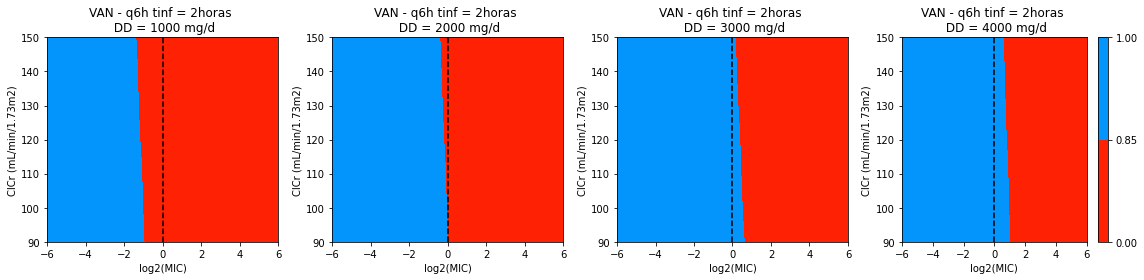

In [26]:
fig, ax = plt.subplots(1,4, figsize=(16,4))

colscal = PTAColorScaleMatplotlib(umbral=0.85)
# Cambio de la dosis diaria
for i,j in enumerate([1000, 2000, 3000, 4000]):
  df = simularANN({'MIC': np.linspace(-6, 6), 'CLCR': np.linspace(90, 150), 'II': 6, 'Tinf': 2, 'DD': j}, estimator, ordenLista)
  grafico3DContorno(ax[i], df['x'][1], df['y'][1], df['z'].reshape((50, 50)), colscal['cmap'], 
                          'log2(MIC)', 'ClCr (mL/min/1.73m2)', 'VAN - q6h tinf = 2horas \n DD = {0} mg/d'.format(j))
  ax[i].vlines(0, 90, 150, linestyle='dashed')

plt.colorbar(cm.ScalarMappable(cmap=colscal['cmap'], norm=colscal['norm']));
fig.set_tight_layout(True)
plt.savefig('013_superficiePTA_CLCR_MIC.pdf')

## Relación de Dosis y CLCR a MIC = 0.0625

In [27]:
MIC_c = np.linspace(-1, +1, 20)

df = []
for i,j in enumerate(MIC_c):
  sim = simularANN({'DD': np.linspace(1000,4000), 'CLCR': np.linspace(90, 150), 'II': 6, 'Tinf': 2, 'MIC': j}, estimator, ordenLista)
  df.append(sim)

In [28]:
frameList = []

for i in range(len(df)):
  frame =  go.Frame(data=go.Surface(
              contours = {
                  "x": {"show": True, "start": 1000, "end": 4000, "size": 500, "color":"white"},
                  "y": {"show": True, "start": 90, "end": 150, "size": 10, "color":"white"},
                  "z": {"show": True, "start": 0, "end": 1, "size": 0.1}
              },
              x = df[i]['x'][1],
              y = df[i]['y'][1],
              z = df[i]['z'].reshape((50, 50)), 
              customdata = [i for i in map(lambda m: 2**m, df[i]['x'][1])],
              hovertemplate = '<b>Dosis</b>: %{x:.2f} <br><b>CLCR</b>: %{y} <br><b>PTA</b>: %{z:.2f}<br>',
              colorscale = PTAColorScalePlotly(),
              ), 
              layout = go.Layout(
                  title = 'Superficie de respuesta ANN - Dosis vs CLCR - MIC {:.3f}'.format(2**(MIC_c[i]))
              ))
  
  frameList.append(frame);

overflow encountered in double_scalars


In [29]:
# df = simularANN({'DD': np.linspace(15, 30), 'CLCR': np.linspace(90, 150), 'ii': 6, 'tinf': 2, 'MIC': -1}, estimator, ordenLista)

fig = go.Figure(go.Surface(
    contours = {
        "x": {"show": True, "start": 1000, "end": 4000, "size": 500, "color":"white"},
        "y": {"show": True, "start": 90, "end": 150, "size": 10, "color":"white"},
        "z": {"show": True, "start": 0, "end": 1, "size": 0.1}
    },
    x = df[0]['x'][1],
    y = df[0]['y'][1],
    z = df[0]['z'].reshape((50, 50)), 
    customdata = [i for i in map(lambda m: 2**m, df[0]['x'][1])],
    hovertemplate = '<b>Dosis</b>: %{x:.2f} <br><b>CLCR</b>: %{y} <br><b>PTA</b>: %{z:.2f}<br>',
    colorscale = PTAColorScalePlotly(), 
    cmin=0.0, cmax=1.0
    ), 
    frames = frameList,
    layout = go.Layout(
        title = 'Superficie de respuesta ANN - Dosis vs CLCR - MIC {:.3f}'.format(2**(MIC_c[0])),
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(label="Iniciar",
                          method="animate",
                          args=[None])]), 
                     ]
    ))

fig.update_layout(
    scene = {
        "xaxis": {"nticks": 6},
        "zaxis": {"nticks": 4},
        'camera_eye': {"x": 0, "y": 1, "z": 0.5},
        "aspectratio": {"x": 1, "y": 1, "z": 0.5},        
        'zaxis': {'range': [0, 1]},
        "xaxis_title": "Dosis (mg/d)",
        "yaxis_title": "CLCR <br> (mL/min)",
        "zaxis_title": "PTA <br> (AUC/MIC > 400)"
        })

# fig.data[0].update(zmin=0.0, zmax=1.0)

fig.show()

fig.write_html("014_superficiePTA_CLCR_Dosis.html")

overflow encountered in double_scalars


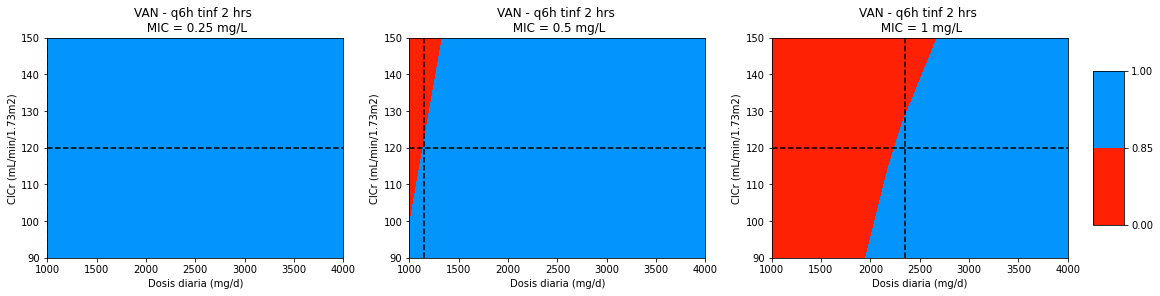

In [30]:
fig, ax = plt.subplots(1,3, figsize=(16,4), constrained_layout=True)

colscal = PTAColorScaleMatplotlib(umbral=0.85)
# Cambio de la dosis diaria
dosisOptima = [1000, 1150, 2350]

for i,j in enumerate([-2,-1,0]):
  df = simularANN({'DD': np.linspace(1000, 4000, 200), 'CLCR': np.linspace(90, 150, 200), 'II': 6, 'Tinf': 2, 'MIC': j}, estimator, ordenLista)
  
  grafico3DContorno(ax[i], df['x'][1], df['y'][1], df['z'].reshape((200, 200)), colscal['cmap'], 
                          'Dosis diaria (mg/d)', 'ClCr (mL/min/1.73m2)', 'VAN - q6h tinf 2 hrs \n MIC = {0} mg/L'.format(2**j))
  ax[i].set_xlim(1000, 4000)
  ax[i].vlines(dosisOptima[i], 90, 150, linestyle='dashed')
  ax[i].hlines(120, 1000, 4000, linestyle='dashed')

plt.colorbar(cm.ScalarMappable(cmap=colscal['cmap'], norm=colscal['norm']), location='right', shrink=0.7);
#fig.set_tight_layout(True)

plt.savefig('015_superficiePTA_CLCR_Dosis.pdf')

## Relación de Dosis y Tiempo de infusión a MIC = 1

In [31]:
df = simularANN({'DD': np.linspace(1000, 4000, 200), 'Tinf': np.linspace(2, 24, 200), 'II': 24, 'CLCR': 120, 'MIC': 0}, estimator, ordenLista)

In [32]:
fig = go.Figure(go.Surface(
    contours = {
        "x": {"show": True, "start": 1000, "end": 4000, "size": 500, "color":"white"},
        "y": {"show": True, "start": 2, "end": 24, "size": 10, "color":"white"},
        "z": {"show": True, "start": 0, "end": 1, "size": 0.1}
    },
    x = df['x'][1],
    y = df['y'][1],
    z = df['z'].reshape((200, 200)), 
    customdata = [i for i in map(lambda m: 2**m, df['x'][1])],
    hovertemplate = '<b>Dosis</b>: %{x:.2f} <br><b>T<sub>inf</sub></b>: %{y} <br><b>PTA</b>: %{z:.2f}<br>',
    colorscale = PTAColorScalePlotly(),
    cmin = 0, cmax = 1
    ))

fig.update_layout(
    title='Superficie de respuesta ANN - Dosis vs T<sub>inf</sub> - MIC: 1 - CLCR: 120mL/min - II: 24h',
    scene = {
        "xaxis": {"nticks": 6},
        "zaxis": {"nticks": 4},
        'camera_eye': {"x": 0, "y": -1, "z": 0.5},
        "aspectratio": {"x": 1, "y": 1, "z": 0.5},
        'zaxis': {'range': [0, 1]},
        "xaxis_title": "Dosis (mg/d)",
        "yaxis_title": "T<sub>inf</sub> <br> (hrs)",
        "zaxis_title": "PTA <br> (AUC/MIC > 400)"
        })
fig.show()

fig.write_html("016_superficiePTA_Dosis_TINF.html")

overflow encountered in double_scalars


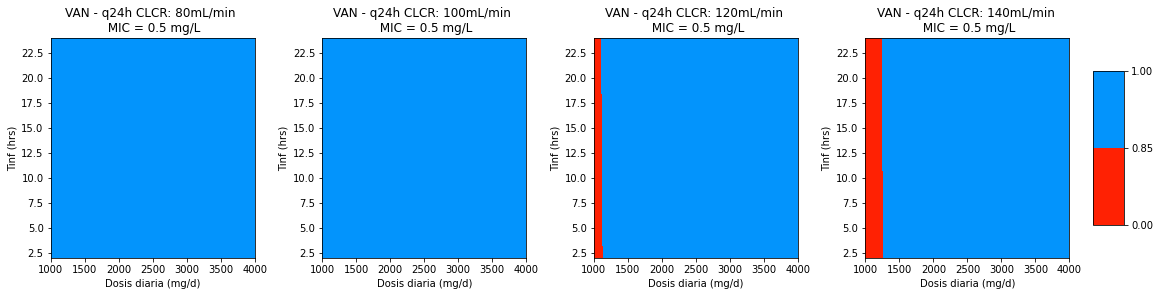

In [33]:
fig, ax = plt.subplots(1,4, figsize=(16,4), constrained_layout=True)

# Cambio de la dosis diaria
#dosisOptima = [16, 22.5, 42]

colscal = PTAColorScaleMatplotlib(umbral=0.85)

for i,j in enumerate([80, 100, 120, 140]):
  df = simularANN({'DD': np.linspace(1000, 4000, 200), 'Tinf': np.linspace(2, 24, 200), 'II': 24, 'CLCR': j, 'MIC': -1}, estimator, ordenLista)
  
  g3D = grafico3DContorno(ax[i], df['x'][1], df['y'][1], df['z'].reshape((200, 200)), colscal['cmap'], 
                          'Dosis diaria (mg/d)', 'Tinf (hrs)', 'VAN - q24h CLCR: {0}mL/min \n MIC = {1} mg/L'.format(j, 2**-1))
  # ax[i].set_xlim(15, 30)
  # ax[i].vlines(dosisOptima[i], 90, 150, linestyle='dashed')
  # ax[i].hlines(120, 15, 30, linestyle='dashed')

plt.colorbar(cm.ScalarMappable(cmap=colscal['cmap'], norm=colscal['norm']), location='right', shrink=0.7);
#fig.set_tight_layout(True)

plt.savefig('017_superficiePTA_Dosis_TINF.pdf')

## Explicación de importancia de predictores

In [34]:
perm = PermutationImportance(estimator, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

Weight,Feature
0.4786 ± 0.0038,MIC
0.0696 ± 0.0012,DD
0.0141 ± 0.0005,CLCR
0.0000 ± 0.0000,Tinf
-0.0000 ± 0.0000,II


In [35]:
def f_wrapper(X):
    return estimator.predict(X).flatten()

X_train_summary = shap.kmeans(X_train, 20)

explainer = shap.KernelExplainer(f_wrapper, X_train_summary)

# Make plot with combined shap values
# The training set is too big so let's sample it. We get enough point to draw conclusions
X_train_sample = X_train.sample(400)
shap_values  = explainer.shap_values(X_train_sample)

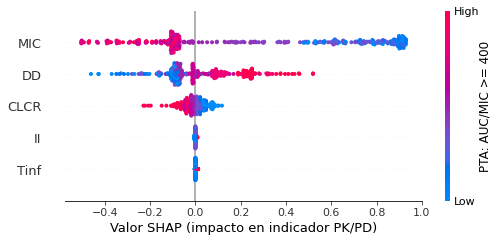

In [36]:
shap.summary_plot(shap_values, X_train_sample,  
                  color_bar_label='PTA: AUC/MIC >= 400', title = 'Impacto de predictores en PTA', show = False)

fig, ax = plt.gcf(), plt.gca()

ax.set_xlabel('Valor SHAP (impacto en indicador PK/PD)')
#ax.set_title('Shap', fontdict={"size":10})

plt.savefig('018_shapValuesPTA_AUCMIC.pdf')

In [37]:
shap.plots.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

In [38]:
shap.plots.initjs()
shap.plots.force(explainer.expected_value, shap_values, X_train_sample,
                 feature_names=['DD', 'ii', 'tinf', 'CLCR', 'MIC'])

In [39]:
files_to_download = [
 "/content/010_Error_Enternamiento.pdf",
 "/content/011_superficiePTA_dosis_MIC.html",
 "/content/012_superficiePTA_CLCR_MIC.html",
 "/content/013_superficiePTA_CLCR_MIC.pdf",
 "/content/014_superficiePTA_CLCR_Dosis.html",
 "/content/015_superficiePTA_CLCR_Dosis.pdf",
 "/content/016_superficiePTA_Dosis_TINF.html",
 "/content/017_superficiePTA_Dosis_TINF.pdf",
 "/content/018_shapValuesPTA_AUCMIC.pdf"
 ]

[files.download(i) for i in files_to_download]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[None, None, None, None, None, None, None, None, None]

No contour levels were found within the data range.


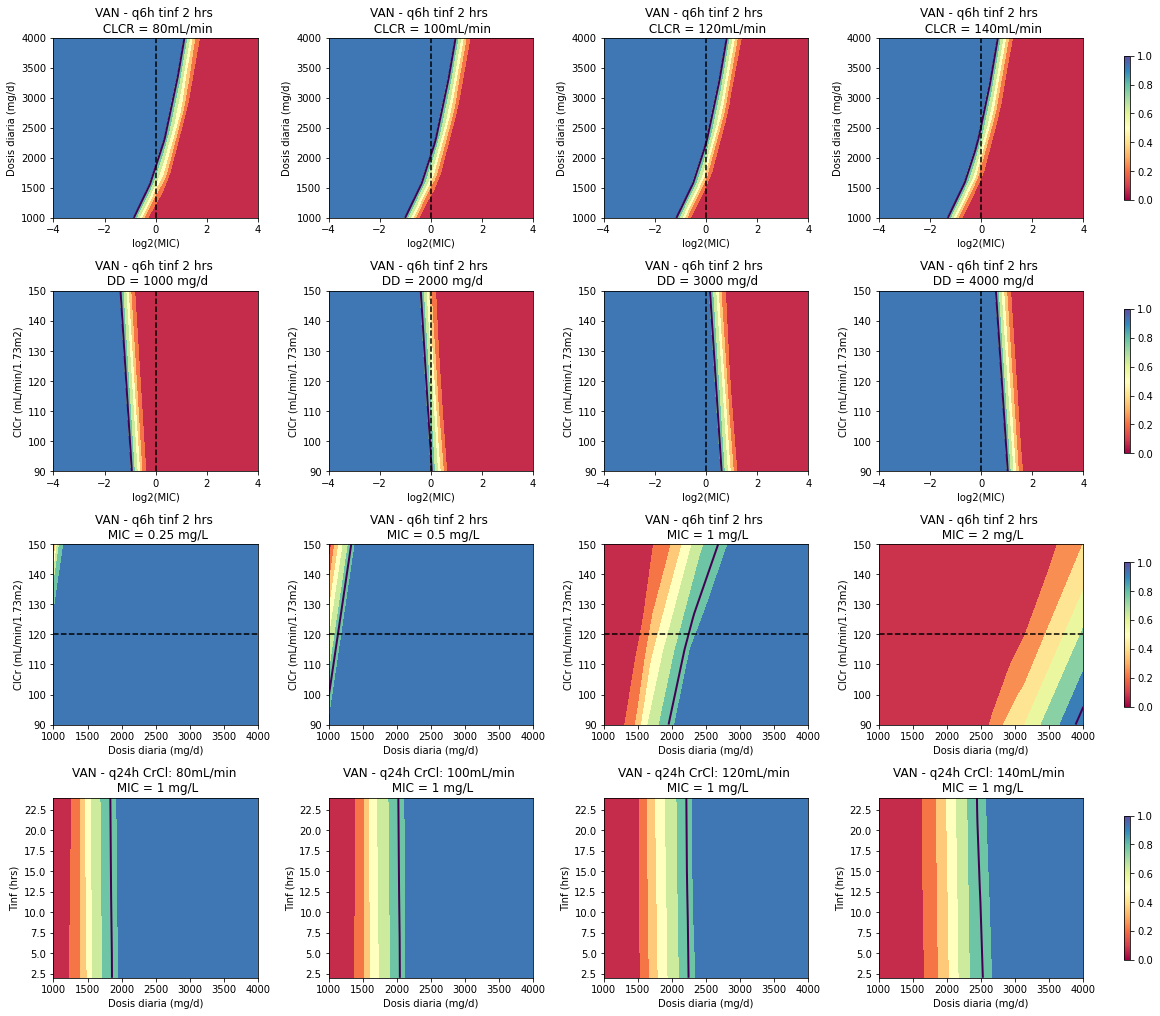

In [40]:
fig, ax = plt.subplots(4,4, figsize=(16,14), constrained_layout=True)
colscal = 'Spectral'

n = 200

modelDict = {'MIC': np.linspace(-4, 4, n), 'DD': np.linspace(1000, 4000, n), 'II': 6, 'Tinf': 2, 'CLCR': 80}
vecCLCR = [80, 100, 120, 140]

for i in range(4):
  modelDict['CLCR'] = vecCLCR[i]
  df = simularANN(modelDict, estimator, ordenLista)
  
  x1, y1 = np.meshgrid(df['x'][1], df['y'][1])
  main = ax[0][i].contourf(x1, y1, df['z'].reshape((n, n)), cmap=colscal)
  csil = ax[0][i].contour(x1, y1, df['z'].reshape((n, n)), levels=[0.85], linewidths=[2], linestyles=('-'))
  
  ax[0][i].set_xlabel('log2(MIC)');  ax[0][i].set_ylabel('Dosis diaria (mg/d)')
  ax[0][i].set_title('VAN - q6h tinf 2 hrs \n CLCR = {}mL/min'.format(vecCLCR[i]))
  ax[0][i].vlines(0, 1000, 4000, linestyle='dashed')

modelDict = {'MIC': np.linspace(-4, 4, n), 'DD': 1000, 'II': 6, 'Tinf': 2, 'CLCR': np.linspace(90,150, n)}
vecDosis = [1000, 2000, 3000, 4000]

for i in range(4):
  modelDict['DD'] = vecDosis[i]
  df = simularANN(modelDict, estimator, ordenLista)
  
  x1, y1 = np.meshgrid(df['x'][1], df['y'][1])
  main = ax[1][i].contourf(x1, y1, df['z'].reshape((n,n)), cmap=colscal)
  csil = ax[1][i].contour(x1, y1, df['z'].reshape((n,n)), levels=[0.85], linewidths=[2], linestyles=('-'))
  
  ax[1][i].set_xlabel('log2(MIC)');  ax[1][i].set_ylabel('ClCr (mL/min/1.73m2)')
  ax[1][i].set_title('VAN - q6h tinf 2 hrs \n DD = {} mg/d'.format(vecDosis[i]))
  ax[1][i].vlines(0, 90, 150, linestyle='dashed')

modelDict = {'MIC': -2, 'DD': np.linspace(1000, 4000, n), 'II': 6, 'Tinf': 2, 'CLCR': np.linspace(90, 150, n)}
vecMIC = [-2, -1, 0, 1]

for i in range(4):
  modelDict['MIC'] = vecMIC[i]
  df = simularANN(modelDict, estimator, ordenLista)
  
  x1, y1 = np.meshgrid(df['x'][1], df['y'][1])
  main = ax[2][i].contourf(x1, y1, df['z'].reshape((n,n)), cmap=colscal)
  csil = ax[2][i].contour(x1, y1, df['z'].reshape((n,n)), levels=[0.85], linewidths=[2], linestyles=('-'))
  
  ax[2][i].set_xlabel('Dosis diaria (mg/d)');  ax[2][i].set_ylabel('ClCr (mL/min/1.73m2)')
  ax[2][i].set_title('VAN - q6h tinf 2 hrs \n MIC = {} mg/L'.format(2**(vecMIC[i])))
  ax[2][i].hlines(120, 1000, 4000, linestyle='dashed')

modelDict = {'MIC': 0, 'DD': np.linspace(1000, 4000, n), 'II': 6, 'Tinf': np.linspace(2, 24, n), 'CLCR': 80}
vecCLCR = [80, 100, 120, 140]

for i in range(4):
  modelDict['CLCR'] = vecCLCR[i]
  df = simularANN(modelDict, estimator, ordenLista)
  
  x1, y1 = np.meshgrid(df['x'][1], df['y'][1])
  main = ax[3][i].contourf(x1, y1, df['z'].reshape((n,n)), cmap=colscal)
  csil = ax[3][i].contour(x1, y1, df['z'].reshape((n,n)), levels=[0.85], linewidths=[2], linestyles=('-'))
  
  ax[3][i].set_xlabel('Dosis diaria (mg/d)');  ax[3][i].set_ylabel('Tinf (hrs)')
  ax[3][i].set_title('VAN - q24h CrCl: {}mL/min \n MIC = 1 mg/L'.format(vecCLCR[i ]))
  #ax[3][i].hlines(120, 1000, 4000, linestyle='dashed')

fig.colorbar(cm.ScalarMappable(cmap=colscal), ax = ax[0], location='right', shrink=0.8);
fig.colorbar(cm.ScalarMappable(cmap=colscal), ax = ax[1], location='right', shrink=0.8);
fig.colorbar(cm.ScalarMappable(cmap=colscal), ax = ax[2], location='right', shrink=0.8);
fig.colorbar(cm.ScalarMappable(cmap=colscal), ax = ax[3], location='right', shrink=0.8);

plt.savefig('019_superficiePTA_dosis_MIC.pdf');

In [41]:
files.download('/content/019_superficiePTA_dosis_MIC.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>